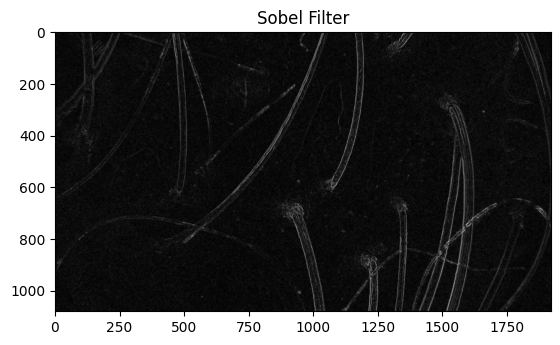

In [92]:
from skimage.feature import local_binary_pattern
import cv2
import matplotlib.pyplot as plt
from skimage.filters import threshold_otsu

image = cv2.imread('./łysienie/03945.jpg', cv2.IMREAD_GRAYSCALE)

sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
sobel_combined = cv2.addWeighted(cv2.convertScaleAbs(sobelx), 0.5, cv2.convertScaleAbs(sobely), 0.5, 0)

plt.imshow(sobel_combined, cmap='gray')
plt.title('Sobel Filter')
plt.show()

In [93]:
thresh = threshold_otsu(sobel_combined)
thresh


np.int64(41)

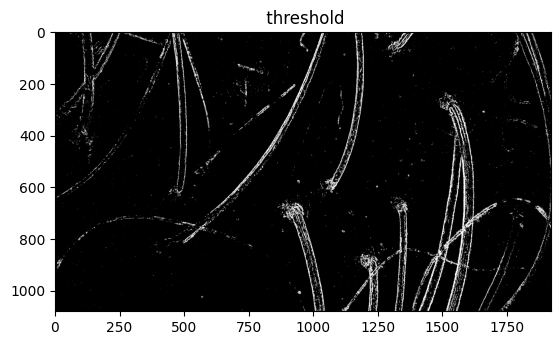

In [94]:
value, threshold = cv2.threshold(sobel_combined, 41, 50, cv2.THRESH_BINARY)

plt.imshow(threshold, cmap='gray')
plt.title(' threshold')
plt.show()

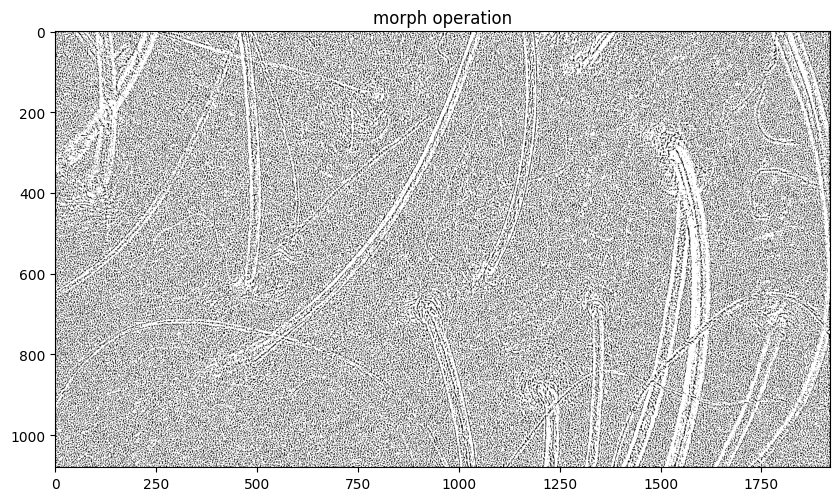

In [80]:
morph = cv2.morphologyEx(threshold, cv2.MORPH_OPEN, (3,3))
plt.figure(figsize=(10,8))
plt.imshow(morph, cmap='gray')
plt.title('morph operation')
plt.show()

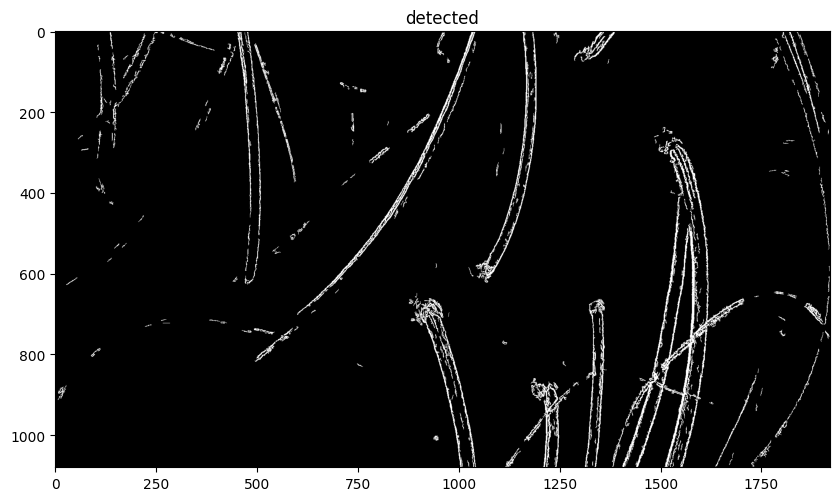

In [101]:
import numpy as np


def detect_counturs(image) -> np.ndarray:

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(image, connectivity=8)
    filtered = np.zeros_like(image)

    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]

        min_area = 10
        if area < min_area:
            continue

        aspect_ratio = max(w, h)
        eccentricity = aspect_ratio / (min(w, h) + 1e-5)
        rect_area = w * h
        fill_ratio = area / (rect_area + 1e-5)

        if aspect_ratio > 10 and eccentricity > 0.1 and fill_ratio < 50.8:
            filtered[labels == i] = 255

    return filtered


detected = detect_counturs(threshold)
plt.figure(figsize=(10,8))
plt.imshow(detected, cmap='gray')
plt.title('detected')
plt.show()

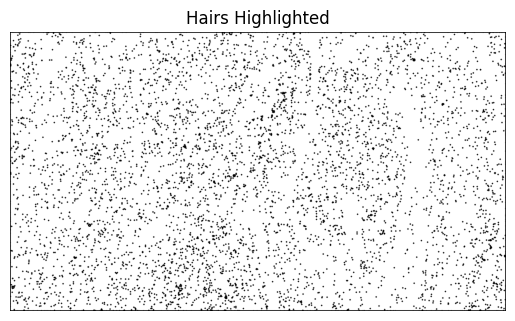

In [95]:
# binary_uint8 = morph.astype(np.uint8)
# inverted_image = cv2.bitwise_not(binary_uint8)
contours, _ = cv2.findContours(sobel_combined, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

# Create a white background
height, width = image.shape
white_canvas = np.ones((height, width, 3), dtype=np.uint8) * 255

# Draw contours in black (or any color)
cv2.drawContours(white_canvas, contours, -1, (0, 0, 0), 3)

# Display result
plt.imshow(white_canvas, cmap='gray')
plt.title("Hairs Highlighted")
plt.axis('off')
plt.show()

In [85]:
morph.shape

(1080, 1920)

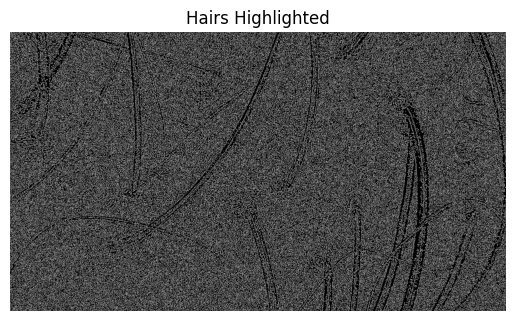

In [88]:


if morph.dtype != np.uint8:
    # Normalize the image to 0-255 range if it's not already
    morph = cv2.normalize(morph, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

canny = cv2.Canny(morph, 20, 40)

plt.imshow(canny, cmap='gray')
plt.title("Hairs Highlighted")
plt.axis('off')
plt.show()

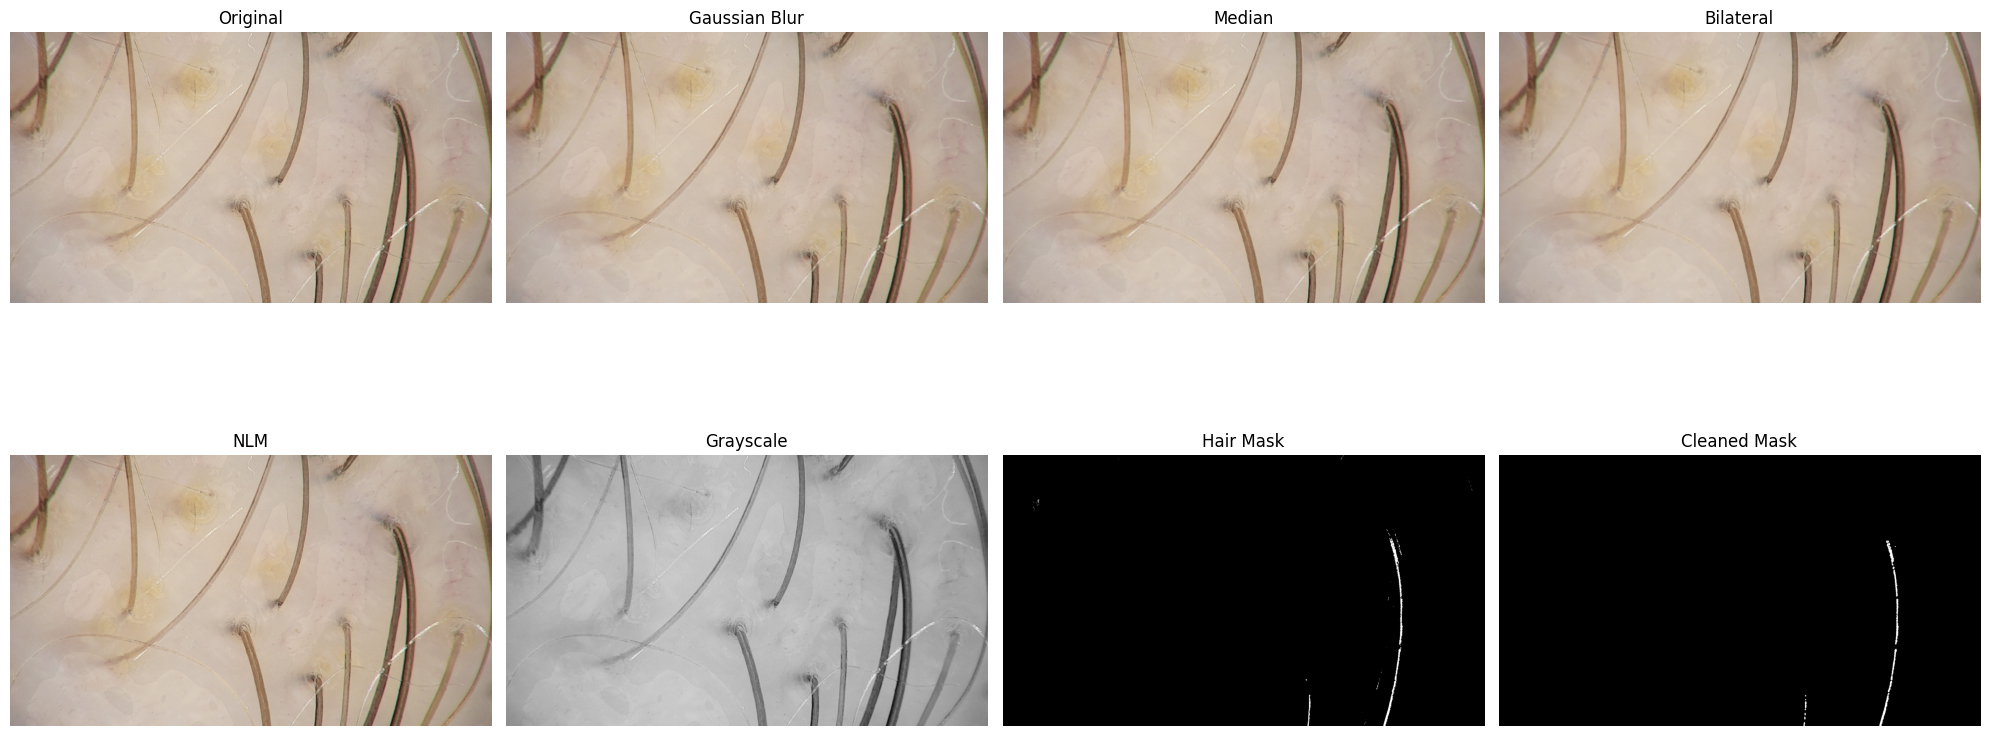

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_float, img_as_ubyte

# Load image
image_path = './łysienie/03945.jpg'  # Change to your image path
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_float = img_as_float(img_rgb)

# Apply different denoising methods
# 1. Gaussian Blur
gaussian = cv2.GaussianBlur(img_rgb, (5, 5), 0)

# 2. Median Filter
median = cv2.medianBlur(img_rgb, 5)

# 3. Bilateral Filter
bilateral = cv2.bilateralFilter(img_rgb, 9, 75, 75)

# 4. Non-local Means Denoising
sigma_est = np.mean(estimate_sigma(img_float, channel_axis=-1))
nlm = denoise_nl_means(img_float, h=1.15 * sigma_est, fast_mode=True,
                       patch_size=5, patch_distance=3, channel_axis=-1)
nlm_uint8 = img_as_ubyte(nlm)

# Choose one (e.g., NLM) for further processing
denoised = nlm_uint8

# Convert to grayscale for hair mask extraction
gray = cv2.cvtColor(denoised, cv2.COLOR_RGB2GRAY)

# Use thresholding to detect darker regions (hair-like)
_, hair_mask = cv2.threshold(gray, 60, 255, cv2.THRESH_BINARY_INV)

# Optional: Morphological cleanup
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
hair_mask_clean = cv2.morphologyEx(hair_mask, cv2.MORPH_OPEN, kernel, iterations=2)

# Plot results
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.ravel()
titles = ['Original', 'Gaussian Blur', 'Median', 'Bilateral', 'NLM', 'Grayscale', 'Hair Mask', 'Cleaned Mask']
images = [img_rgb, gaussian, median, bilateral, nlm_uint8, gray, hair_mask, hair_mask_clean]

for i in range(8):
    axs[i].imshow(images[i], cmap='gray' if i >= 5 else None)
    axs[i].set_title(titles[i])
    axs[i].axis('off')

plt.tight_layout()
plt.show()


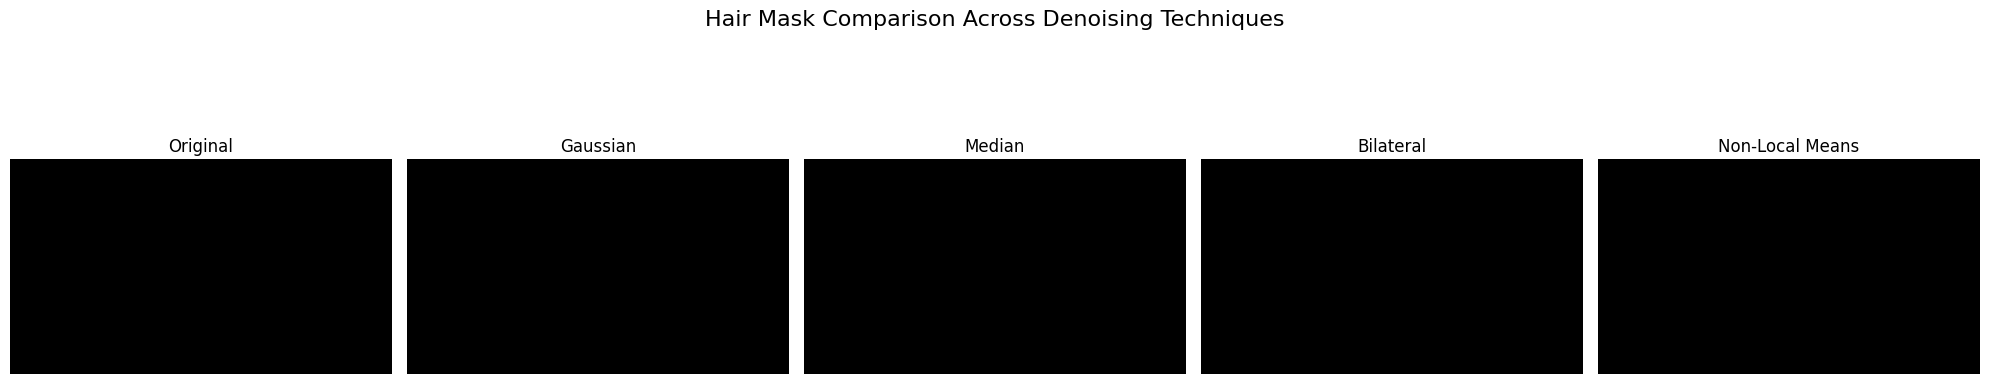

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_float, img_as_ubyte

# Load image
image_path = './łysienie/03945.jpg'  # Replace with your actual image path
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_float = img_as_float(img_rgb)

# ----------------- Denoising -------------------
gaussian = cv2.GaussianBlur(img_rgb, (5, 5), 0)
median = cv2.medianBlur(img_rgb, 5)
bilateral = cv2.bilateralFilter(img_rgb, 9, 75, 75)

sigma_est = np.mean(estimate_sigma(img_float, channel_axis=-1))
nlm = denoise_nl_means(img_float, h=1.15 * sigma_est, fast_mode=True,
                       patch_size=5, patch_distance=3, channel_axis=-1)
nlm_uint8 = img_as_ubyte(nlm)

# ----------------- Hair Mask Function -------------------
def extract_hair_mask(image_rgb):
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 20, 80, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)
    return cleaned

# ----------------- Get Masks -------------------
original_mask = extract_hair_mask(img_rgb)
gaussian_mask = extract_hair_mask(gaussian)
median_mask = extract_hair_mask(median)
bilateral_mask = extract_hair_mask(bilateral)
nlm_mask = extract_hair_mask(nlm_uint8)

# ----------------- Plot Comparison -------------------
fig, axs = plt.subplots(1, 5, figsize=(20, 5))
titles = ['Original', 'Gaussian', 'Median', 'Bilateral', 'Non-Local Means']
masks = [original_mask, gaussian_mask, median_mask, bilateral_mask, nlm_mask]

for i in range(5):
    axs[i].imshow(masks[i], cmap='gray')
    axs[i].set_title(titles[i])
    axs[i].axis('off')

plt.suptitle("Hair Mask Comparison Across Denoising Techniques", fontsize=16)
plt.tight_layout()
plt.show()


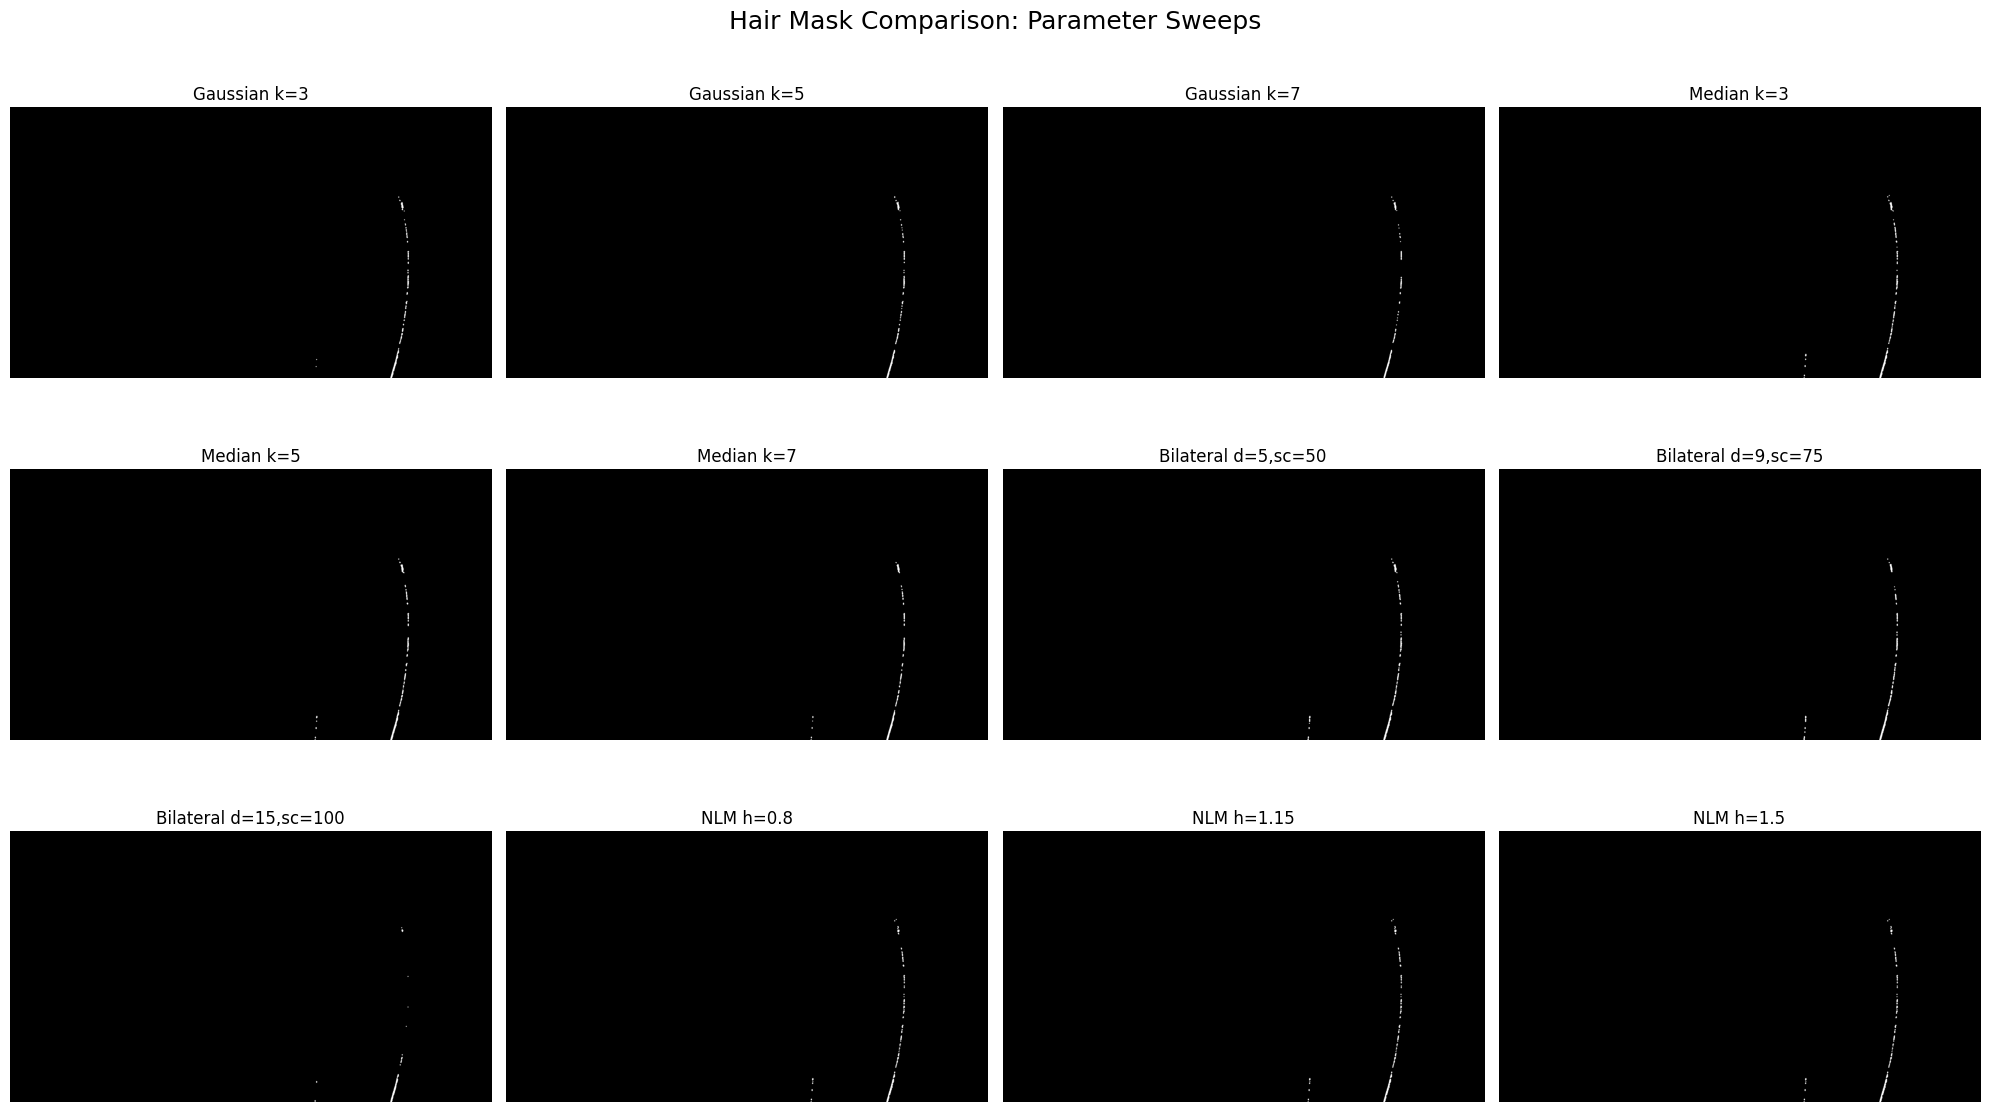

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage import img_as_float, img_as_ubyte

# Load image
image_path = './łysienie/03945.jpg'  # Replace with your image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_float = img_as_float(img_rgb)

# Utility: Extract hair mask
def extract_hair_mask(image_rgb):
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 50, 120, cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    cleaned = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=2)
    return cleaned

# Collect all results
results = []

# ---------- Gaussian ----------
for k in [3, 5, 7]:
    blurred = cv2.GaussianBlur(img_rgb, (k, k), 0)
    mask = extract_hair_mask(blurred)
    results.append((f'Gaussian k={k}', mask))

# ---------- Median ----------
for k in [3, 5, 7]:
    median = cv2.medianBlur(img_rgb, k)
    mask = extract_hair_mask(median)
    results.append((f'Median k={k}', mask))

# ---------- Bilateral ----------
bilateral_params = [(5, 50, 50), (9, 75, 75), (15, 100, 100)]
for d, sc, ss in bilateral_params:
    bilateral = cv2.bilateralFilter(img_rgb, d, sc, ss)
    mask = extract_hair_mask(bilateral)
    results.append((f'Bilateral d={d},sc={sc}', mask))

# ---------- Non-Local Means ----------
sigma_est = np.mean(estimate_sigma(img_float, channel_axis=-1))
for h in [0.8, 1.15, 1.5]:
    nlm = denoise_nl_means(img_float, h=h * sigma_est, fast_mode=True,
                           patch_size=5, patch_distance=3, channel_axis=-1)
    nlm_uint8 = img_as_ubyte(nlm)
    mask = extract_hair_mask(nlm_uint8)
    results.append((f'NLM h={round(h,2)}', mask))

# ---------- Plot Results ----------
cols = 4
rows = int(np.ceil(len(results) / cols))
fig, axs = plt.subplots(rows, cols, figsize=(20, rows * 4))
axs = axs.ravel()

for i in range(len(results)):
    title, mask = results[i]
    axs[i].imshow(mask, cmap='gray')
    axs[i].set_title(title)
    axs[i].axis('off')

# Hide unused subplots
for j in range(len(results), len(axs)):
    axs[j].axis('off')

plt.suptitle("Hair Mask Comparison: Parameter Sweeps", fontsize=18)
plt.tight_layout()
plt.show()


In [ ]:
import cv2
import numpy as np
from skimage import exposure
import matplotlib.pyplot as plt

def preprocess_skin_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Image not found or path is incorrect")

    # Image Scaling
    scale_percent = 50  # percent of original size
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_image = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)

    # Color Space Transformation
    gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
    lab_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2LAB)

    # Contrast Enhancement
    enhanced_image = exposure.equalize_hist(gray_image)

    # Image Restoration: Denoising
    denoised_image = cv2.fastNlMeansDenoisingColored(resized_image, None, 10, 10, 7, 21)

    # Image Restoration: Deblurring (simplified example)
    deblurred_image = cv2.GaussianBlur(denoised_image, (0, 0), 1)

    # Hair Removal (simplified example using morphological operations)
    kernel = np.ones((5, 5), np.uint8)
    morphology_image = cv2.morphologyEx((enhanced_image * 255).astype(np.uint8), cv2.MORPH_OPEN, kernel)

    return {
        "resized_image": cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB),
        "gray_image": gray_image,
        "enhanced_image": enhanced_image,
        "denoised_image": cv2.cvtColor(denoised_image, cv2.COLOR_BGR2RGB),
        "deblurred_image": cv2.cvtColor(deblurred_image, cv2.COLOR_BGR2RGB),
        "morphology_image": morphology_image
    }

def plot_images(results):
    titles = [
        'Resized Image', 'Gray Image', 'Enhanced Image',
        'Denoised Image', 'Deblurred Image', 'Morphology Image'
    ]
    images = [
        results["resized_image"], results["gray_image"], results["enhanced_image"],
        results["denoised_image"], results["deblurred_image"], results["morphology_image"]
    ]

    plt.figure(figsize=(15, 8))
    for i in range(len(images)):
        plt.subplot(2, 3, i + 1)
        if images[i].ndim == 2:
            plt.imshow(images[i], cmap='gray')
        else:
            plt.imshow(images[i])
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Example usage
image_path = './łysienie/03945.jpg'
results = preprocess_skin_image(image_path)
plot_images(results)
